# 1. import packages

In [1]:
import argparse
import scAGDE
import scanpy as sc

Warning message:
package ‘methods’ was built under R version 4.2.2 
During startup - Warning messages:
1: package ‘datasets’ was built under R version 4.2.2 
2: package ‘utils’ was built under R version 4.2.2 
3: package ‘grDevices’ was built under R version 4.2.2 
4: package ‘graphics’ was built under R version 4.2.2 
5: package ‘stats’ was built under R version 4.2.2 


# 2. configurations

In [2]:
parser = argparse.ArgumentParser(description='scAGDE')
parser.add_argument('--data', type=str, default='data/Forebrain.h5ad')
parser.add_argument('--n_centroids', '-k', type=int, help='cluster number', default=8)
parser.add_argument('--gpu', '-g', type=int, default=0, help='GPU id to use.')
parser.add_argument('--seed', type=int, default=25, help='Random seed for repeat results')
parser.add_argument('--model', type=str, default=None, help='Load the trained model')
parser.add_argument('--verbose', "-v", action='store_false')
parser.add_argument('--outdir', '-o', type=str, default='output', help='Output path')
args = parser.parse_args(args=[])

scagde = scAGDE.Trainer(n_centroids=args.n_centroids, gpu=args.gpu, seed=args.seed, verbose=args.verbose, outdir=args.outdir)

device used: cuda:0



# 3. data preparation

You can directly use the following code to read files in h5ad format or write one yourself.The `binary` parameter determines whether binarisation is performed (default is True).

In [3]:
adata = scAGDE.utils.prepare_data(datapath=args.data,binary=True)
X = adata.X.toarray()

Loading dataset from:data/Forebrain.h5ad


# 4. run scAGDE

We provide two ways of runnning scAGDE, as shown in `4.1` and `4.2`.

## 4.1 run scAGDE in 'step-by-step' style

Firstly, a chromatin accessibility-based autoencoder is used to project the raw data into the low-dimensional space and search for neighbours for each cell in this space to constitute a cell graph.

In [4]:
A_hat = scagde.CountModel(X)

Cell number: 2088
Peak number: 11285
n_centroids: 8


## Training CountModel ##


CountModel: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:32<00:00, 152.97it/s, loss=1686.2892]



## Constructing Cell Graph ##


Meanwhile,the importance score of each peak is calculated based on the weights of the encoder module.Use the code below to plot the distribution of importance scores and choose the number of peaks to keep.

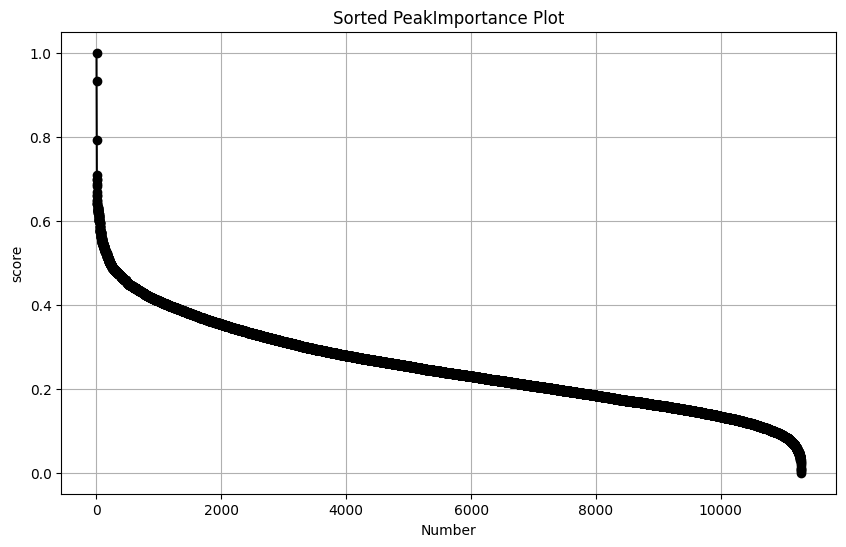

In [5]:
scagde.plotPeakImportance()

In [6]:
# Choose any moment after the scoring curve has flattened out, for example, 100000.
X, idx = scagde.peakSelect(X, topn=10000, return_idx=True)

The graph learning module is utilised to obtain the final embedding as well as clustering results. `impute` determines whether or not to return the estimated true chromatin accessibility landscapes (default is True).

In [7]:
cluster, embedding, impute = scagde.GraphModel(X, A_hat, impute=True)

Cell number: 2088
Peak number: 10000
n_centroids: 8


## Training GraphModel ##


GraphModel: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:55<00:00, 72.72it/s, loss=783.3793]


## 4.2 run scAGDE in 'end-to-end' style

Alternatively, you can simply omit the intermediate steps and run scAGDE in end-to-end way as below:

In [8]:
# cluster, embedding, impute = scagde.fit(X, impute=True, topn=10000)

## clustering evaluation

In [9]:
y = adata.obs["celltype"].astype("category").cat.codes.values
if y.min() > 0:
    y -= y.min()
res = scAGDE.utils.cluster_report(y, cluster.astype(float).astype(int))


## Clustering Evaluation Report ##
# Confusion matrix: #
[[113   0   1   0   0   3   0   3]
 [  0 173   8   8   0   0   0   1]
 [  1   4 325  27   6   2   0   1]
 [  1  30  67 413   2   2   0   4]
 [  1   2   2   2 187   1   0   0]
 [ 32   1   7   4   7 266   0   3]
 [  1   1   2   9   2   1 107   3]
 [  0   0   0   0   0   0   0 252]]
# Metric values: #
Adjusted Rand Index score: 0.7232
`Normalized Mutual Info score: 0.7647
`f1 score: 0.8793


# 5. Integration with Scanpy

/tmp/ipykernel_66901/2036752497.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var["is_selected"][idx] = 1
/tmp/ipykernel_66901/2036752497.py:4: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a futu

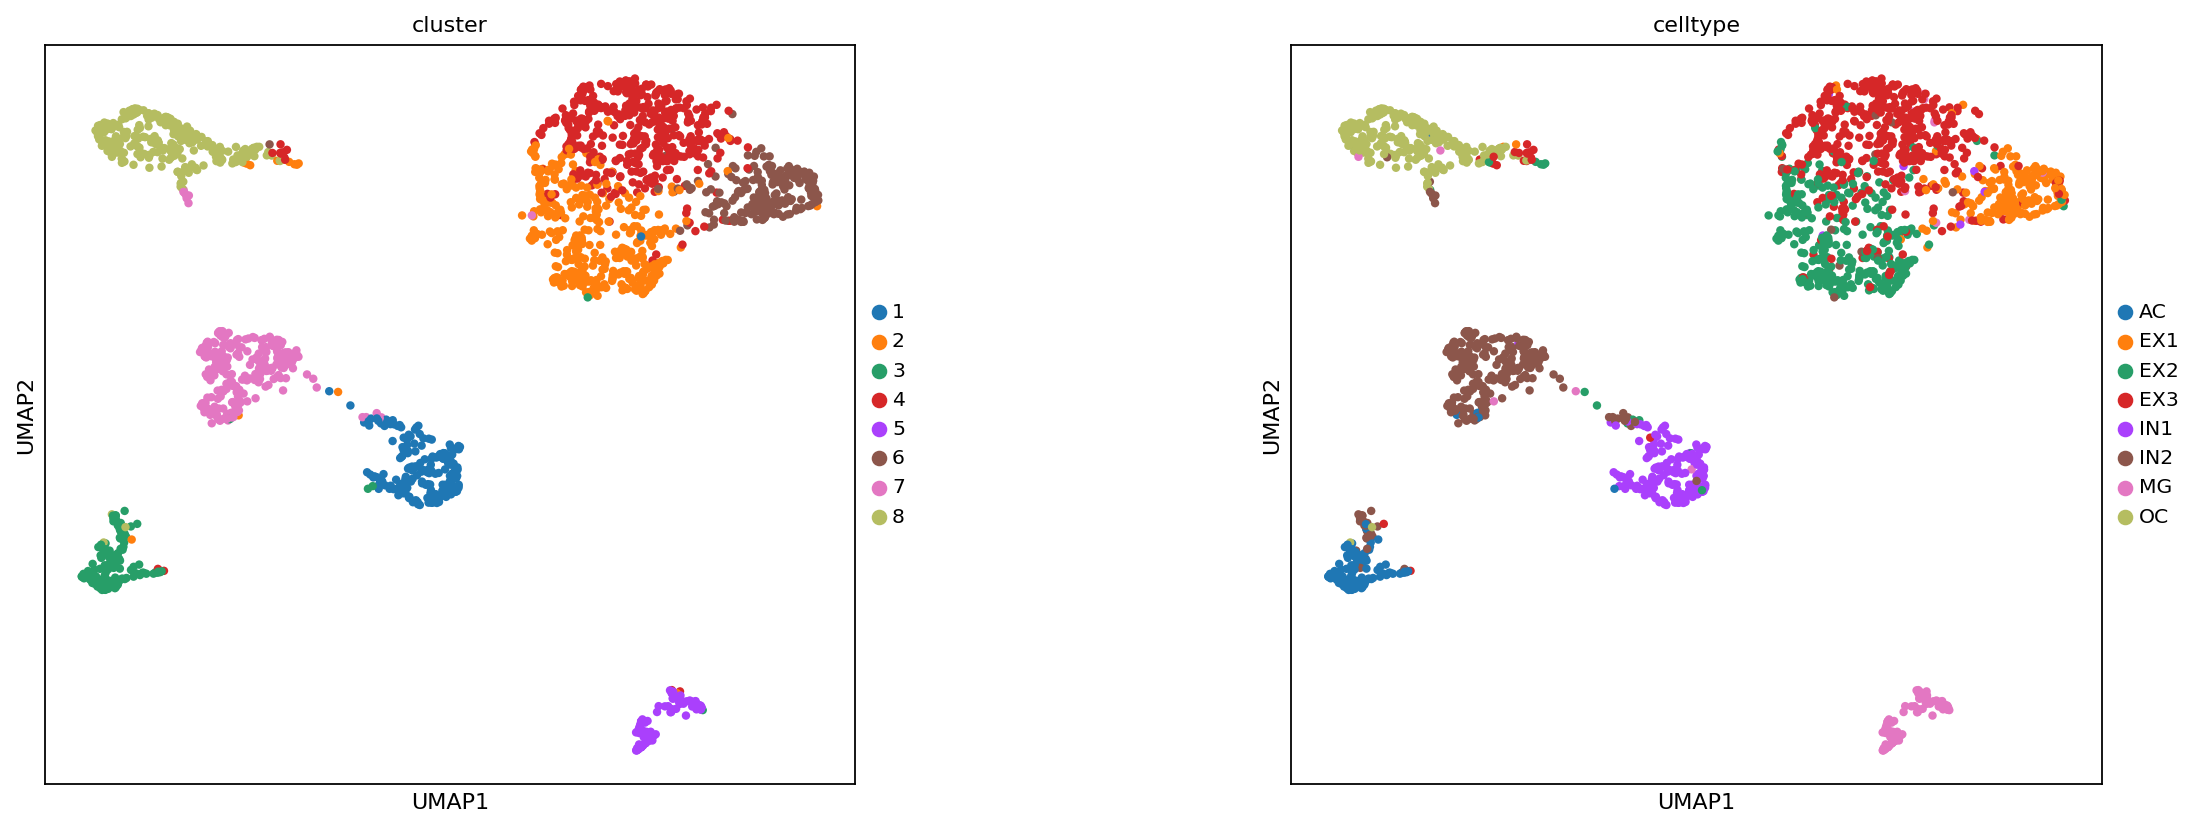

In [10]:
adata.obsm["latent"] = embedding
adata.obs["cluster"] = cluster
adata.var["is_selected"] = 0
adata.var["is_selected"][idx] = 1
sc.pp.neighbors(adata, n_neighbors=30, use_rep='latent')
sc.set_figure_params(dpi=80, figsize=(6, 6), fontsize=10)
sc.tl.umap(adata, min_dist=0.1)
color = [c for c in ["cluster", "celltype"] if c in adata.obs]
sc.pl.umap(adata, color=color, wspace=0.4, ncols=4, show=True)